# Import packages

In [1]:
from atgfe.GeneticFeatureEngineer import GeneticFeatureEngineer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, make_scorer, f1_score, precision_score, log_loss
from yellowbrick.classifier import ClassificationReport, ConfusionMatrix, ROCAUC, PrecisionRecallCurve
from lightgbm import LGBMClassifier
from yellowbrick.datasets import load_spam

In [2]:
dataset = load_spam(return_dataset=True)
df = dataset.to_dataframe()
df.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,is_spam
0,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
1,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
2,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,1.85,0.00,0.00,1.85,0.00,0.00,...,0.00,0.223,0.0,0.000,0.000,0.000,3.000,15,54,1


In [3]:
target = 'is_spam'
columns = df.drop(target, axis=1).columns.tolist()

In [4]:
X = df.drop(target, axis=1).copy()
Y = df.loc[:, target].copy()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=77)

In [5]:
classes=['ham', 'spam']

In [6]:
def classification_report(model):
    visualizer = ClassificationReport(model, classes=classes, support=True)
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)  
    visualizer.poof()                 

In [7]:
def roc_auc(model):
    visualizer = ROCAUC(model, classes=classes)
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)  
    visualizer.poof()     

In [8]:
def confusion_matrix(model):
    visualizer = ConfusionMatrix(model, classes=classes)
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)  
    visualizer.poof()     

In [9]:
def precision_recall_curve(model):
    visualizer = PrecisionRecallCurve(model)
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)  
    visualizer.poof()     

In [10]:
def score_model(model, X, y):
    evaluation_metric_scorer = make_scorer(accuracy_score, greater_is_better=True)
    scores = cross_val_score(estimator=model, X=X, y=y, cv=10, scoring=evaluation_metric_scorer, n_jobs=-1)
    scores_mean = scores.mean()
    score_std = scores.std()
    print('Mean of metric: {}, std: {}'.format(scores_mean, score_std))

In [11]:
def create_new_model():
    return make_pipeline(StandardScaler(), LogisticRegression(n_jobs=-1, random_state=7))

# Using LightGBM

In [12]:
lgbm_model = LGBMClassifier(random_state=7)

In [13]:
score_model(lgbm_model, X, Y)

Mean of metric: 0.9445395494800769, std: 0.02758077800120883


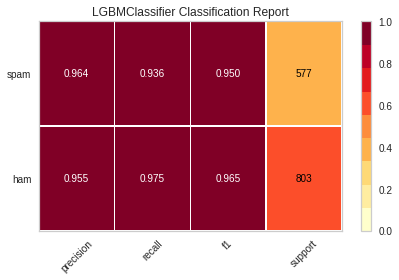

In [14]:
classification_report(lgbm_model)

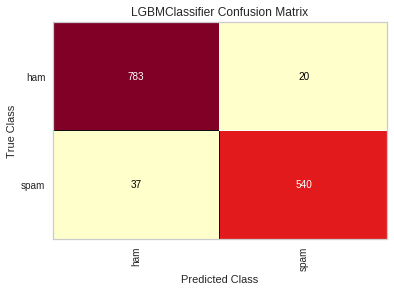

In [15]:
confusion_matrix(lgbm_model)

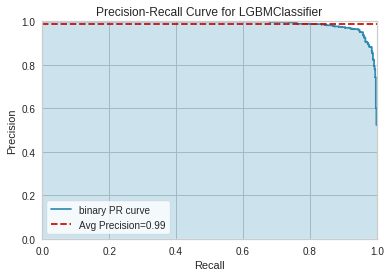

In [16]:
precision_recall_curve(lgbm_model)

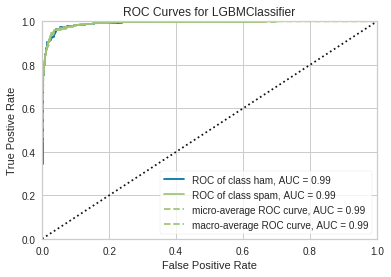

In [17]:
roc_auc(lgbm_model)

# Using Logistic Regression

In [18]:
model = create_new_model()

In [19]:
score_model(model, X, Y)

Mean of metric: 0.9171467749601019, std: 0.02893657901607086


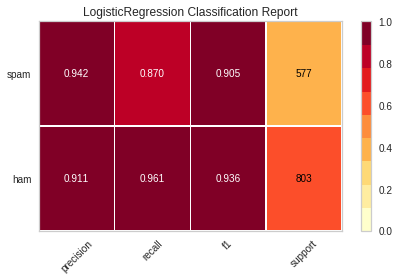

In [20]:
classification_report(model)

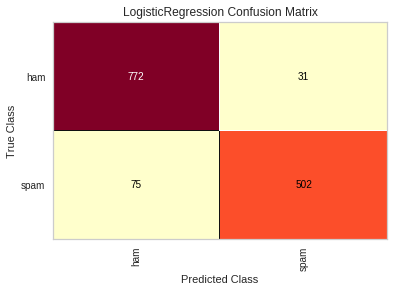

In [21]:
confusion_matrix(model)

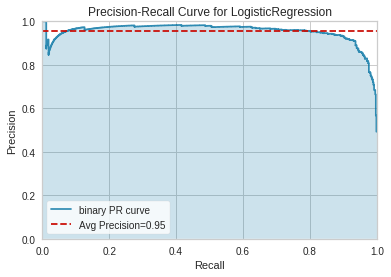

In [22]:
precision_recall_curve(model)

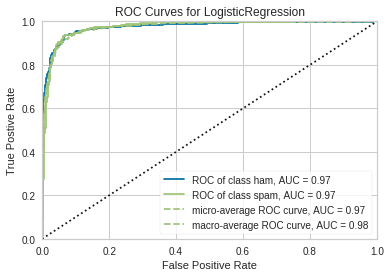

In [23]:
roc_auc(model)

# Using ATgfe

In [24]:
model = create_new_model()

In [25]:
def prepare_column_names(columns):
    return [col.replace(';', 'semi')
            .replace('(', 'left_brace')
            .replace('[', 'left_bracket')
            .replace('$', 'dollar_sign')
            .replace('#', 'hash')
            .replace('!', 'explanation_mark')
            for col in columns]

columns = prepare_column_names(df.columns.tolist())
df.columns = columns

X = df.drop(target, axis=1).copy()
Y = df.loc[:, target].copy()

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=77)
columns = X.columns.tolist()

In [27]:
gfe = GeneticFeatureEngineer(model, x_train=X_train, y_train=y_train, numerical_features=columns,
                             number_of_candidate_features=21,
                             number_of_interacting_features=5,
                             evaluation_metric=accuracy_score, minimize_metric=False, verbose=True, cv=10,
                            fit_wo_original_columns=False, enable_feature_transformation_operations=False, enable_weights=False)

2019-11-16 09:01:58,912:INFO: New Engineer created with the following parameters: 
2019-11-16 09:01:58,914:INFO: 
Model type: <class 'sklearn.pipeline.Pipeline'>
Numerical Features: ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail', 'word_freq_receive', 'word_freq_will', 'word_freq_people', 'word_freq_report', 'word_freq_addresses', 'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you', 'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000', 'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george', 'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet', 'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85', 'word_freq_technology', 'word_freq_1999', 'word_freq_parts', 'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting', 'word_freq_original', 'word_freq_p

In [28]:
gfe.fit(population_size=2000, early_stopping_patience=10)

2019-11-16 09:02:00,283:INFO: Start of evolution 
2019-11-16 09:02:53,384:INFO:   Evaluated 2000 individuals 
2019-11-16 09:02:53,387:INFO: -- Generation 1 -- 
2019-11-16 09:04:15,866:INFO:   Evaluated 1244 individuals 
2019-11-16 09:04:15,874:INFO:   Min -1000000000000.0 
2019-11-16 09:04:15,875:INFO:   Max 0.9322671683913453 
2019-11-16 09:04:15,876:INFO:   Avg -246449999999.6027 
2019-11-16 09:04:15,876:INFO:   Std 391608730112.33856 
2019-11-16 09:04:18,162:INFO: Generation: 1, validation scores: [0.91950464 0.92879257 0.94117647 0.9380805  0.91331269 0.9470405
 0.93146417 0.95950156 0.92523364 0.90342679], mean_score: 0.9307533539731683 
2019-11-16 09:04:18,164:INFO: Generation: 1, best solution features: ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail', 'word_freq_receive', 'word_freq_will', 'word_freq_people', 'word_freq_report', 'word_freq_add

# Apply GFE

In [29]:
X = gfe.transform(X)

In [30]:
X.head(20)

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_edu*word_freq_order + word_freq_lab,word_freq_people,capital_run_length_total*char_freq_explanation_mark + word_freq_credit*word_freq_hp,capital_run_length_average/capital_run_length_total - char_freq_hash*word_freq_original,-char_freq_left_bracket + word_freq_font + word_freq_table,word_freq_parts*(char_freq_semi + word_freq_remove),word_freq_data*(word_freq_hpl + word_freq_report) - word_freq_remove + word_freq_will,word_freq_remove,word_freq_george*word_freq_your,word_freq_3d*word_freq_meeting - word_freq_telnet
0,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.0000,0.65,382.416,0.004975,0.0,0.0,0.58,0.21,0.0,0.0
1,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.0384,0.12,623.484,0.003147,0.0,0.0,0.26,0.19,0.0,0.0
2,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.0000,0.31,26.167,0.018518,0.0,0.0,0.00,0.31,0.0,0.0
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.0000,0.31,25.785,0.018518,0.0,0.0,0.00,0.31,0.0,0.0
4,0.00,0.00,0.00,0.0,1.85,0.00,0.00,1.85,0.00,0.00,...,0.0000,0.00,0.000,0.055556,0.0,0.0,0.00,0.00,0.0,0.0
5,0.00,0.00,0.00,0.0,1.92,0.00,0.00,0.00,0.00,0.64,...,0.0000,0.00,18.368,0.014920,0.0,0.0,1.28,0.00,0.0,0.0
6,0.00,0.00,0.00,0.0,1.88,0.00,0.00,1.88,0.00,0.00,...,0.0000,0.00,0.000,0.050000,0.0,0.0,0.00,0.00,0.0,0.0
7,0.15,0.00,0.46,0.0,0.61,0.00,0.30,0.00,0.92,0.76,...,0.0000,0.00,227.517,0.001152,0.0,0.0,0.62,0.30,0.0,0.0
8,0.06,0.12,0.77,0.0,0.19,0.32,0.38,0.00,0.06,0.00,...,0.0000,0.25,182.756,0.002308,0.0,0.0,0.26,0.38,0.0,0.0
9,0.00,0.00,0.00,0.0,0.00,0.00,0.96,0.00,0.00,1.92,...,0.0000,0.00,9.702,0.062476,0.0,0.0,-0.96,0.96,0.0,0.0


In [31]:
model = create_new_model()

In [32]:
score_model(model, X, Y)

Mean of metric: 0.9291009573687061, std: 0.029527720036015136


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=77)

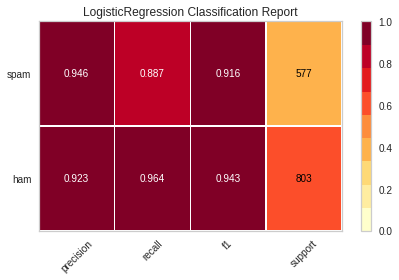

In [34]:
classification_report(model)

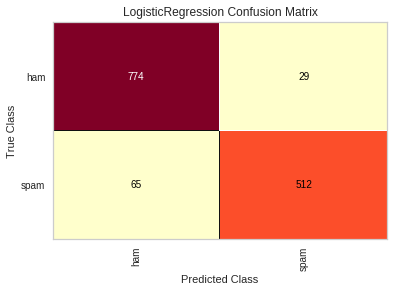

In [35]:
confusion_matrix(model)

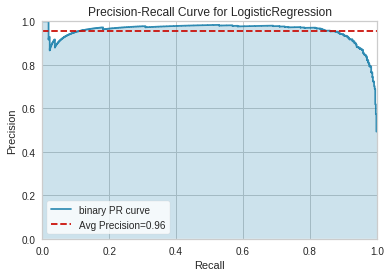

In [36]:
precision_recall_curve(model)

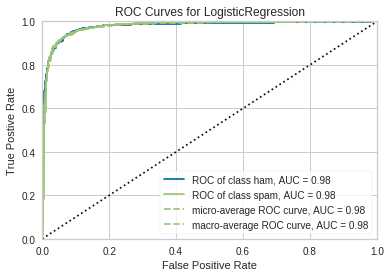

In [37]:
roc_auc(model)

# Run ATgfe with operations and weights

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=77)
columns = X.columns.tolist()

In [49]:
gfe = GeneticFeatureEngineer(model, x_train=X_train, y_train=y_train, numerical_features=columns,
                             number_of_candidate_features=20,
                             number_of_interacting_features=4,
                             evaluation_metric=accuracy_score, minimize_metric=True, verbose=True, cv=10,
                            fit_wo_original_columns=False, enable_feature_transformation_operations=True, enable_weights=True)

2019-11-16 10:55:20,053:INFO: New Engineer created with the following parameters: 
2019-11-16 10:55:20,055:INFO: 
Model type: <class 'sklearn.pipeline.Pipeline'>
Numerical Features: ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail', 'word_freq_receive', 'word_freq_will', 'word_freq_people', 'word_freq_report', 'word_freq_addresses', 'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you', 'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000', 'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george', 'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet', 'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85', 'word_freq_technology', 'word_freq_1999', 'word_freq_parts', 'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting', 'word_freq_original', 'word_freq_p

In [50]:
gfe.fit(population_size=2000, early_stopping_patience=10)

2019-11-16 10:55:22,346:INFO: Start of evolution 
2019-11-16 10:55:49,210:INFO:   Evaluated 2000 individuals 
2019-11-16 10:55:49,211:INFO: -- Generation 1 -- 
2019-11-16 10:56:07,023:INFO:   Evaluated 1204 individuals 
2019-11-16 10:56:07,030:INFO:   Min 1000000000.0 
2019-11-16 10:56:07,031:INFO:   Max 100000000000.0 
2019-11-16 10:56:07,032:INFO:   Avg 5752000000.0 
2019-11-16 10:56:07,033:INFO:   Std 21162856517.965805 
2019-11-16 10:56:07,041:INFO: -- Generation 2 -- 
2019-11-16 10:56:25,155:INFO:   Evaluated 1239 individuals 
2019-11-16 10:56:25,164:INFO:   Min 0.9416745061147695 
2019-11-16 10:56:25,165:INFO:   Max 100000000000.0 
2019-11-16 10:56:25,166:INFO:   Avg 4860500000.000471 
2019-11-16 10:56:25,167:INFO:   Std 19166012620.00011 
2019-11-16 10:56:27,128:INFO: Generation: 2, validation scores: [0.91950464 0.93188854 0.94117647 0.9504644  0.91640867 0.95638629
 0.93146417 0.95327103 0.93146417 0.90965732], mean_score: 0.934168571511241 
2019-11-16 10:56:27,131:INFO: Gener

In [51]:
X = gfe.transform(X)

In [52]:
model = create_new_model()

In [53]:
score_model(model, X, Y)

Mean of metric: 0.9310565380332816, std: 0.030036169771776828


In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=77)

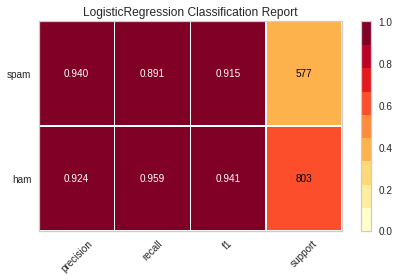

In [55]:
classification_report(model)

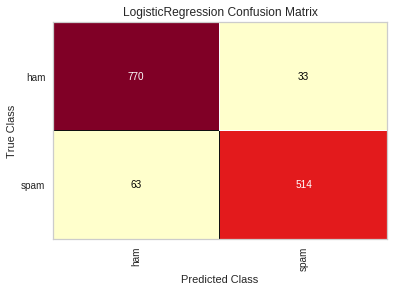

In [56]:
confusion_matrix(model)

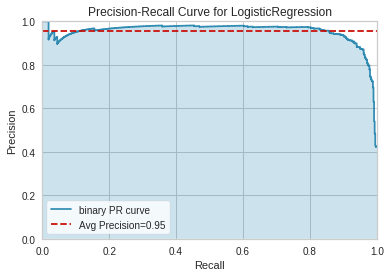

In [57]:
precision_recall_curve(model)

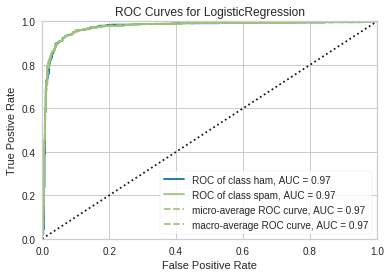

In [58]:
roc_auc(model)